# Result Analyze

## Associativity

In [23]:
# open associativity_data.csv in read
with open("associativity_data.csv", "r") as file:
    data = file.read()

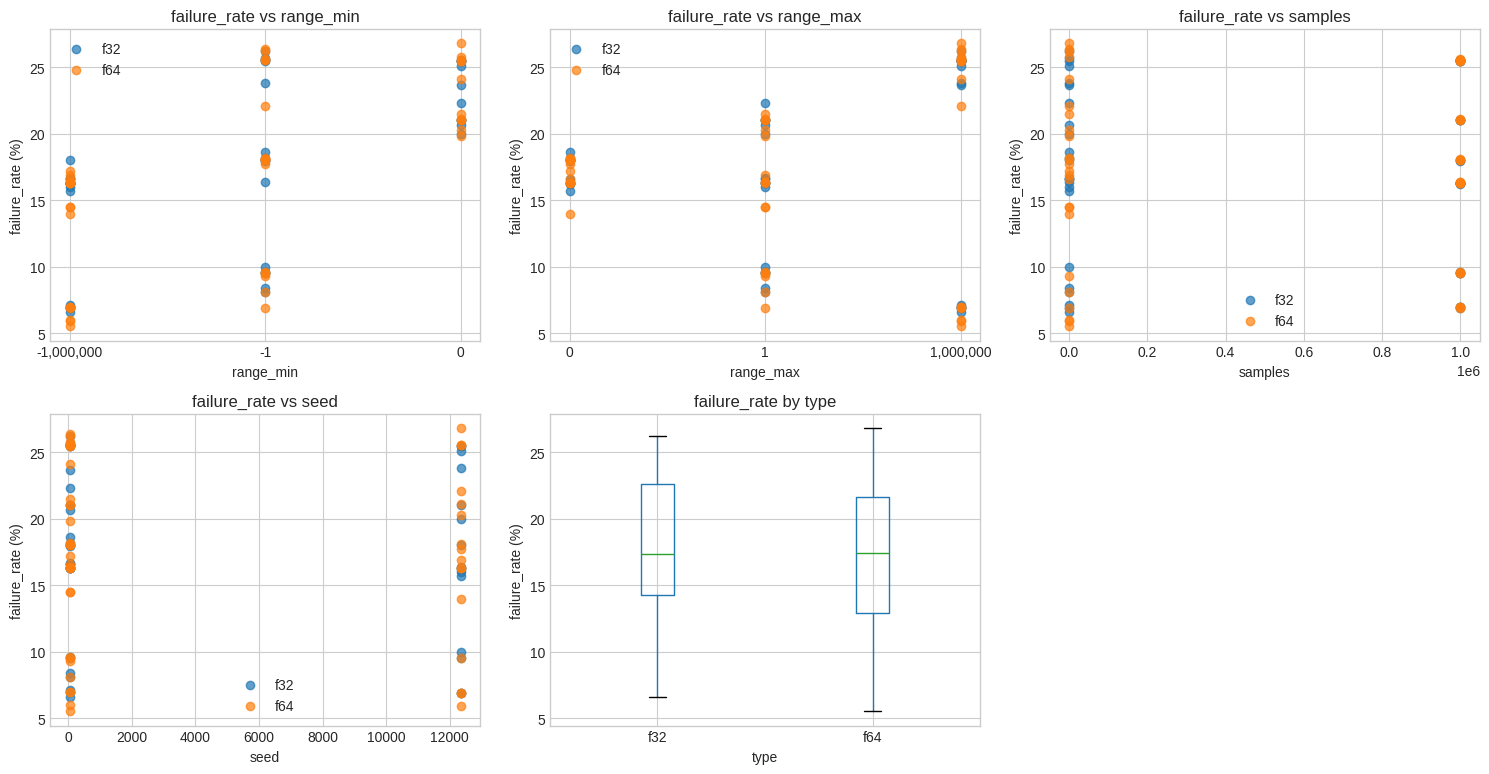

In [24]:
import io
import pandas as pd

import matplotlib.pyplot as plt

# load CSV from the existing `data` string
df = pd.read_csv(io.StringIO(data))

# clean failure_rate column (remove % and convert to float)
df['failure_rate'] = df['failure_rate'].str.rstrip('%').astype(float)

# ensure numeric types for plotting
for col in ['range_min', 'range_max', 'samples', 'seed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create plots: failure_rate vs each parameter, colored by 'type'
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

params = ['range_min', 'range_max', 'samples', 'seed']

# define categorical orders for range_min and range_max to avoid linear numeric spacing
range_orders = {
    'range_min': [-1000000, -1, 0],
    'range_max': [0, 1, 1000000],
}

for i, param in enumerate(params):
    ax = axes[i]
    if param in range_orders:
        order = range_orders[param]
        mapping = {v: idx for idx, v in enumerate(order)}
        for t, g in df.groupby('type'):
            x = g[param].map(mapping)
            ax.scatter(x, g['failure_rate'], label=t, alpha=0.7)
        ax.set_xticks(list(mapping.values()))
        ax.set_xticklabels([f"{v:,}" for v in order])
    else:
        for t, g in df.groupby('type'):
            ax.scatter(g[param], g['failure_rate'], label=t, alpha=0.7)
    ax.set_xlabel(param)
    ax.set_ylabel('failure_rate (%)')
    ax.set_title(f'failure_rate vs {param}')
    ax.legend()

# boxplot of failure_rate by type
ax = axes[4]
df.boxplot(column='failure_rate', by='type', ax=ax)
ax.set_title('failure_rate by type')
ax.set_xlabel('type')
ax.set_ylabel('failure_rate (%)')
plt.suptitle('')

# hide the unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

**explanation**: The different variables used in the analysis are as follows:
- `type`: The floating-point type used in the computations, either `f32` (32-bit float) or `f64` (64-bit float).
- `range_min`: The minimum value of the range from which random floating-point numbers were generated (-1000000, -1 or 0)
- `range_max`: The maximum value of the range from which random floating-point numbers were generated (0, 1 or 1000000)
- `samples`: The number of random samples generated for each experiment (1000 or 1000000)
- `seed`: The seed value used to initialize the random number generator, ensuring reproducibility of the experiments (40, 42, 12345)

By plotting and analyzing these variables against the `failure_rate`, we can identify patterns and insights into how different configurations affect the accuracy of floating-point computations in terms of associativity violations.
The `range_min` seems to have a significant impact on the failure rate, with negative ranges leading to lower failure rates. `range_max` also influences the failure rate, with larger positive ranges resulting in higher failure rates but less than `range_min`. 
The `samples` variable shows almost no effect on the failure rate, indicating that the number of samples does not significantly impact the likelihood of associativity violations in this context. The `seed` variable does not impact `failure_rate`. The `type` shows that `f32` has a slightly higher failure rate compared to `f64`, which is expected due to the lower precision of 32-bit floats. 

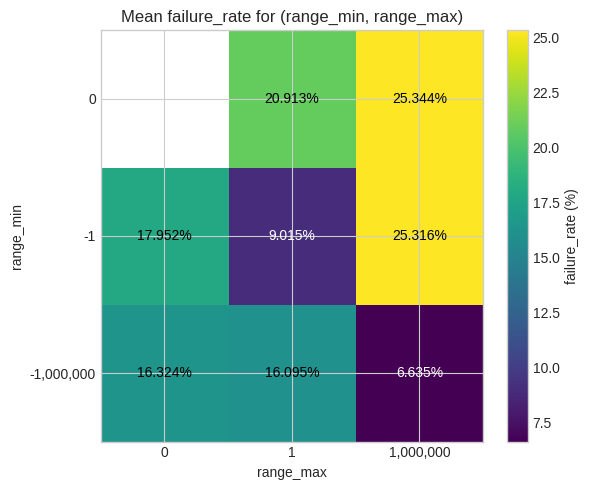

In [25]:
# heatmap of failure_rate for (range_min, range_max) using categorical (non-linear) ordering
order_min = [-1000000, -1, 0]
order_max = [0, 1, 1000000]

# map to ordinal indices for plotting
map_min = {v: i for i, v in enumerate(order_min)}
map_max = {v: i for i, v in enumerate(order_max)}
df['range_min_idx'] = df['range_min'].map(map_min)
df['range_max_idx'] = df['range_max'].map(map_max)

# pivot to get mean failure_rate for each (range_min, range_max) cell
pivot = df.pivot_table(index='range_min_idx', columns='range_max_idx', values='failure_rate', aggfunc='mean')

# ensure full grid (fill missing with NaN)
pivot = pivot.reindex(index=range(len(order_min)), columns=range(len(order_max)))

# plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(pivot.values, origin='lower', cmap='viridis', aspect='auto')

# ticks: show original range values (formatted)
xticks = np.arange(len(order_max))
yticks = np.arange(len(order_min))
plt.xticks(xticks, [f"{v:,}" for v in order_max])
plt.yticks(yticks, [f"{v:,}" for v in order_min])
plt.xlabel('range_max')
plt.ylabel('range_min')
plt.title('Mean failure_rate for (range_min, range_max)')

# annotate cells with mean failure_rate
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.iat[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.3f}%", ha='center', va='center', color='white' if val < (np.nanmax(pivot.values) + np.nanmin(pivot.values))/2 else 'black')

plt.colorbar(im, label='failure_rate (%)')
plt.tight_layout()
plt.show()

**explanation**: 
When analyzing the impact of `range_min` vs `range_max` on the `failure_rate`, we can see that `range_min` has a more pronounced effect. This might be explained by the fact that negative values can lead to more significant rounding errors in floating-point arithmetic, especially when combined with positive values.

Decision tree rules:
|--- range_min <= -0.5000
|   |--- range_min <= -500000.5000
|   |   |--- range_max <= 500000.5000
|   |   |   |--- value: [16.2097]
|   |   |--- range_max >  500000.5000
|   |   |   |--- value: [6.6349]
|   |--- range_min >  -500000.5000
|   |   |--- range_max <= 500000.5000
|   |   |   |--- value: [13.4833]
|   |   |--- range_max >  500000.5000
|   |   |   |--- value: [25.3164]
|--- range_min >  -0.5000
|   |--- range_max <= 500000.5000
|   |   |--- seed <= 6193.5000
|   |   |   |--- value: [21.0590]
|   |   |--- seed >  6193.5000
|   |   |   |--- value: [20.6207]
|   |--- range_max >  500000.5000
|   |   |--- seed <= 6193.5000
|   |   |   |--- value: [25.1449]
|   |   |--- seed >  6193.5000
|   |   |   |--- value: [25.7431]



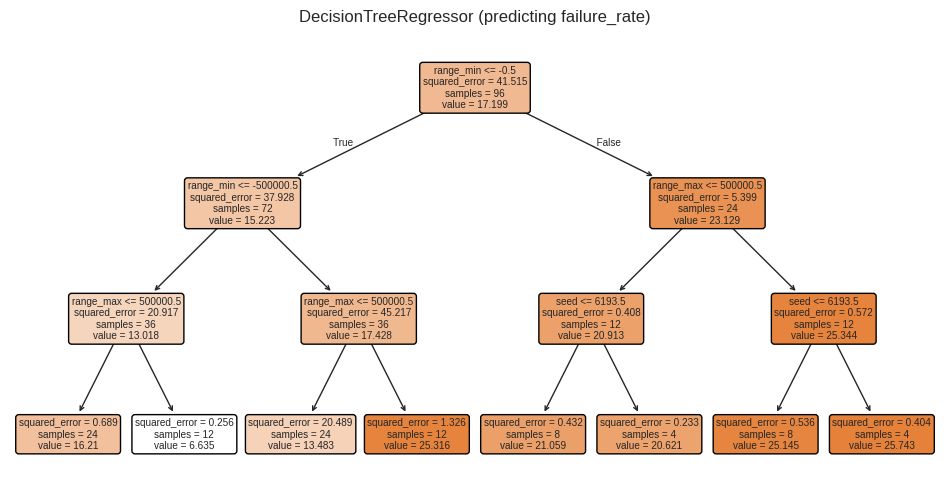

Best leaf id: 4, predicted failure_rate = 6.6349%
Rule for best leaf (conditions to minimize failure_rate):
 - range_min <= -0.5000
 - range_min <= -500000.5000
 - range_max > 500000.5000

Examples of parameter settings in this leaf (most common):
type  range_min  range_max  samples  seed 
f32   -1000000   1000000    1000     40       1
                                     42       1
                                     12345    1
                            1000000  40       1
                                     42       1
                                     12345    1
f64   -1000000   1000000    1000     40       1
                                     42       1
                                     12345    1
                            1000000  40       1
Name: count, dtype: int64

Type encoding map: {0: 'f32', 1: 'f64'}


In [26]:
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Decision tree to find parameter regions that minimize failure_rate

# prepare data (uses existing df)
feat_cols = ['type', 'range_min', 'range_max', 'samples', 'seed']
X = df[feat_cols].copy()

# encode categorical 'type'
le = LabelEncoder()
X['type_enc'] = le.fit_transform(X['type'])
X = X[['type_enc', 'range_min', 'range_max', 'samples', 'seed']]

y = df['failure_rate']

# train an interpretable tree
reg = DecisionTreeRegressor(max_depth=3, random_state=0)
reg.fit(X, y)

# print textual rules
feature_names = ['type_enc', 'range_min', 'range_max', 'samples', 'seed']
print("Decision tree rules:")
print(export_text(reg, feature_names=feature_names, decimals=4))

# plot the tree for visual inspection
plt.figure(figsize=(12,6))
plot_tree(reg, feature_names=feature_names, filled=True, rounded=True, precision=3)
plt.title("DecisionTreeRegressor (predicting failure_rate)")
plt.show()

# find leaf nodes and the one with lowest predicted failure_rate
leaf_ids = reg.apply(X)
preds = reg.predict(X)
leaf_stats = {}
for leaf, pred_val in zip(leaf_ids, preds):
    leaf_stats.setdefault(leaf, []).append(pred_val)
leaf_mean = {leaf: np.mean(vals) for leaf, vals in leaf_stats.items()}
best_leaf = min(leaf_mean, key=leaf_mean.get)
print(f"Best leaf id: {best_leaf}, predicted failure_rate = {leaf_mean[best_leaf]:.4f}%")

# helper to extract human-readable rule for a leaf
tree = reg.tree_
def find_path(node_id, target_leaf, path):
    if node_id == target_leaf and tree.children_left[node_id] == -1:
        return path
    if tree.children_left[node_id] == -1:
        return None
    # left branch
    f = feature_names[tree.feature[node_id]]
    thr = tree.threshold[node_id]
    left_path = find_path(tree.children_left[node_id], target_leaf, path + [f"{f} <= {thr:.4f}"])
    if left_path:
        return left_path
    right_path = find_path(tree.children_right[node_id], target_leaf, path + [f"{f} > {thr:.4f}"])
    return right_path

rule = find_path(0, best_leaf, [])
print("Rule for best leaf (conditions to minimize failure_rate):")
for cond in rule:
    print(" -", cond)

# show the most common parameter combinations that fall into that leaf
rows_in_best = df[leaf_ids == best_leaf]
print("\nExamples of parameter settings in this leaf (most common):")
print(rows_in_best[feat_cols].value_counts().head(10))

# decode type_enc back to original labels for clarity
print("\nType encoding map:", dict(enumerate(le.classes_)))

**explanation**: 
The decision tree analysis further supports these observations. The tree identifies `range_min` and `range_max` as the most important features influencing the `failure_rate`, with specific thresholds that delineate regions of higher and lower failure rates. For instance, when `range_min` is less than -500000 and `range_max` is greater than 500000, the failure rate tends to be higher. Conversely, when both `range_min` and `range_max` are closer to zero, the failure rate decreases significantly.

## Investment

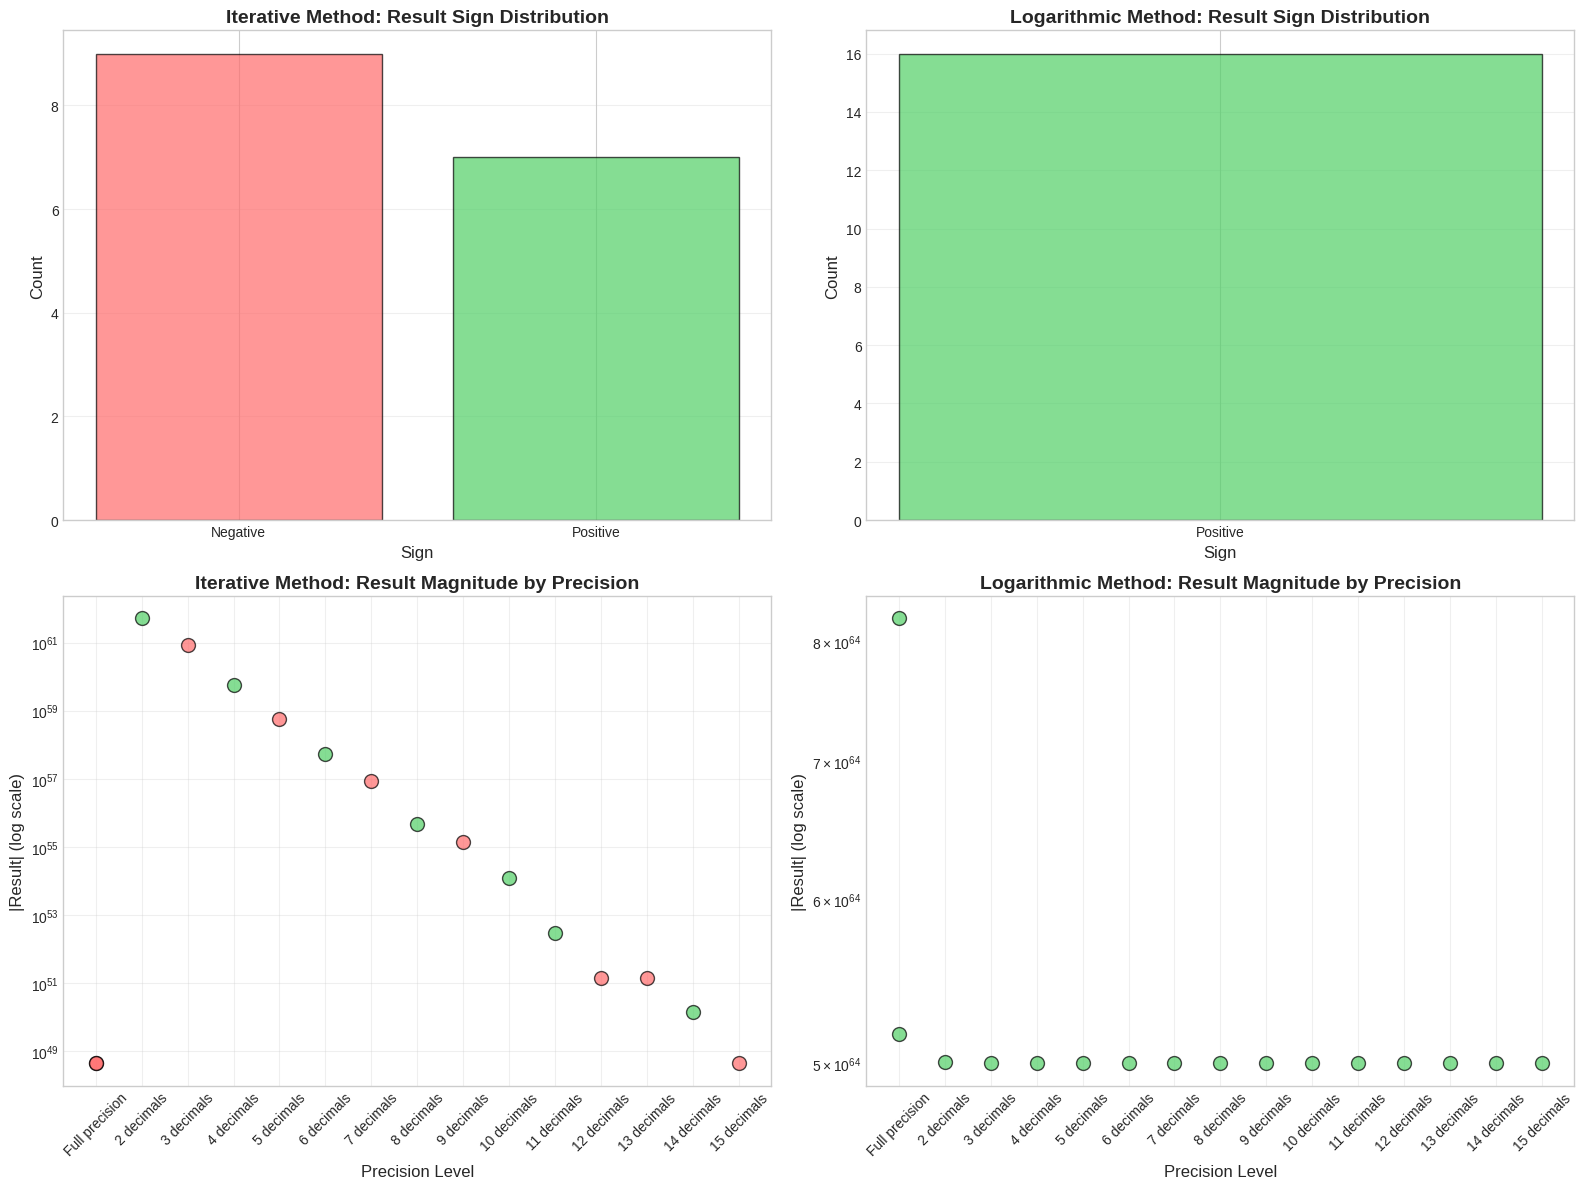

INVESTMENT DATA ANALYSIS SUMMARY

### ITERATIVE METHOD ###
Total computations: 16
Negative results: 9 (56.2%)
Positive results: 7 (43.8%)

### LOGARITHMIC METHOD ###
Total computations: 16
Negative results: 0 (0.0%)
Positive results: 16 (100.0%)

### ITERATIVE METHOD: RESULTS BY PRECISION ###
Full precision       → Negative (result: -4.40e+48)
2 decimals           → Positive (result: 5.23e+61)
3 decimals           → Negative (result: -8.57e+60)
4 decimals           → Positive (result: 5.53e+59)
5 decimals           → Negative (result: -5.56e+58)
6 decimals           → Positive (result: 5.22e+57)
7 decimals           → Negative (result: -8.66e+56)
8 decimals           → Positive (result: 4.69e+55)
9 decimals           → Negative (result: -1.40e+55)
10 decimals          → Positive (result: 1.25e+54)
11 decimals          → Positive (result: 2.90e+52)
12 decimals          → Negative (result: -1.38e+51)
13 decimals          → Negative (result: -1.38e+51)
14 decimals          → Positive (res

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the investment data
df = pd.read_csv('investment_data.csv')

# Convert result column to numeric
df['result'] = pd.to_numeric(df['result'], errors='coerce')


# Add a column to identify if result is positive or negative
df['sign'] = df['result'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Extract precision level from description
def extract_precision(desc):
    if 'core::f64::consts::E' in desc:
        return 'Full precision'
    else:
        # Extract number of decimals
        parts = desc.split('to ')
        if len(parts) > 1:
            return parts[1].split(' ')[0] + ' decimals'
    return desc

df['precision'] = df['description'].apply(extract_precision)

# Separate by method
iterative_df = df[df['method'] == 'iterative'].copy()
logarithmic_df = df[df['method'] == 'logarithmic'].copy()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sign distribution for Iterative method
ax1 = axes[0, 0]
iterative_signs = iterative_df['sign'].value_counts()
colors_iter = ['#ff6b6b' if sign == 'Negative' else '#51cf66' for sign in iterative_signs.index]
ax1.bar(iterative_signs.index, iterative_signs.values, color=colors_iter, alpha=0.7, edgecolor='black')
ax1.set_title('Iterative Method: Result Sign Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Sign', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Sign distribution for Logarithmic method
ax2 = axes[0, 1]
logarithmic_signs = logarithmic_df['sign'].value_counts()
colors_log = ['#ff6b6b' if sign == 'Negative' else '#51cf66' for sign in logarithmic_signs.index]
ax2.bar(logarithmic_signs.index, logarithmic_signs.values, color=colors_log, alpha=0.7, edgecolor='black')
ax2.set_title('Logarithmic Method: Result Sign Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Sign', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# 3. Result magnitude by precision (Iterative) - log scale
ax3 = axes[1, 0]
# Sort by number of decimals for better visualization
precision_order_iter = sorted(iterative_df['precision'].unique(),
                              key=lambda x: 0 if x == 'Full precision' else int(x.split()[0]))
for prec in precision_order_iter:
    subset = iterative_df[iterative_df['precision'] == prec]
    color = '#ff6b6b' if subset['sign'].iloc[0] == 'Negative' else '#51cf66'
    ax3.scatter([prec] * len(subset), np.abs(subset['result']),
                color=color, alpha=0.7, s=100, edgecolor='black')

ax3.set_yscale('log')
ax3.set_title('Iterative Method: Result Magnitude by Precision', fontsize=14, fontweight='bold')
ax3.set_ylabel('|Result| (log scale)', fontsize=12)
ax3.set_xlabel('Precision Level', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(alpha=0.3)

# 4. Result magnitude by precision (Logarithmic) - log scale
ax4 = axes[1, 1]
precision_order_log = sorted(logarithmic_df['precision'].unique(),
                             key=lambda x: 0 if x == 'Full precision' else int(x.split()[0]))
for prec in precision_order_log:
    subset = logarithmic_df[logarithmic_df['precision'] == prec]
    color = '#ff6b6b' if subset['sign'].iloc[0] == 'Negative' else '#51cf66'
    ax4.scatter([prec] * len(subset), np.abs(subset['result']),
                color=color, alpha=0.7, s=100, edgecolor='black')

ax4.set_yscale('log')
ax4.set_title('Logarithmic Method: Result Magnitude by Precision', fontsize=14, fontweight='bold')
ax4.set_ylabel('|Result| (log scale)', fontsize=12)
ax4.set_xlabel('Precision Level', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 80)
print("INVESTMENT DATA ANALYSIS SUMMARY")
print("=" * 80)
print("\n### ITERATIVE METHOD ###")
print(f"Total computations: {len(iterative_df)}")
print(f"Negative results: {(iterative_df['sign'] == 'Negative').sum()} ({(iterative_df['sign'] == 'Negative').sum() / len(iterative_df) * 100:.1f}%)")
print(f"Positive results: {(iterative_df['sign'] == 'Positive').sum()} ({(iterative_df['sign'] == 'Positive').sum() / len(iterative_df) * 100:.1f}%)")

print("\n### LOGARITHMIC METHOD ###")
print(f"Total computations: {len(logarithmic_df)}")
print(f"Negative results: {(logarithmic_df['sign'] == 'Negative').sum()} ({(logarithmic_df['sign'] == 'Negative').sum() / len(logarithmic_df) * 100:.1f}%)")
print(f"Positive results: {(logarithmic_df['sign'] == 'Positive').sum()} ({(logarithmic_df['sign'] == 'Positive').sum() / len(logarithmic_df) * 100:.1f}%)")

# Detailed breakdown by precision
print("\n### ITERATIVE METHOD: RESULTS BY PRECISION ###")
for prec in precision_order_iter:
    subset = iterative_df[iterative_df['precision'] == prec]
    sign = subset['sign'].iloc[0]
    result = subset['result'].iloc[0]
    print(f"{prec:20s} → {sign:8s} (result: {result:.2e})")

print("\n### LOGARITHMIC METHOD: RESULTS BY PRECISION ###")
for prec in precision_order_log:
    subset = logarithmic_df[logarithmic_df['precision'] == prec]
    sign = subset['sign'].iloc[0]
    result = subset['result'].mean()  # Average if multiple entries
    print(f"{prec:20s} → Positive (result: {result:.2e})")

print("=" * 80)


**explanation**:
The analysis of the investment data reveals distinct patterns in the results of the two computational methods: iterative and logarithmic.

Using the iterative method, we get about half of the test cases going to negative infinity and half to positive infinity, whether we have to round the initial value of e up or down. This method is very sensitive to rounding errors.

The logarithmic method is not supposed to be affected by rounding errors as much, but evidently our implementation still is. We get consistancy at least, with all the test cases going to positive infinity.